# Submission Figures

In [23]:
import sys
# This makes the gdc19 package avaialble
sys.path.append('../')
import gdc19
gdc19.setup()

'/Volumes/GoogleDrive/My Drive/utah-forge'

In [24]:
import pandas as pd
import numpy as np
import vtki
import omfvtk
import PVGeo
import matplotlib.pyplot as plt

In [25]:
vtki.set_plot_theme('doc')
vtki.rcParams['font']['size'] = 12
vtki.rcParams['font']['title_size'] = 12
vtki.rcParams['font']['label_size'] = 12
vtki.rcParams['use_panel'] = False

In [26]:
proj = gdc19.load_project()

In [27]:
# Add values to the meshes so colors are consistent with other data
# try:
temp_175c = proj['temp_175c']
temp_225c = proj['temp_225c']
temp_175c.point_arrays['Temperature'] = np.full(proj['temp_175c'].n_points, 175.)
temp_225c.point_arrays['Temperature'] = np.full(proj['temp_225c'].n_points, 225.)
#     tc = vtki.MultiBlock()
#     tc['temp_175c'] = proj['temp_175c']
#     tc['temp_225c'] = proj['temp_225c']
#     tc.save(gdc19.get_surfaces_path('temp-surfaces.vtm'))
# except:
#     import logging
#     logging.warning('issue.')

In [28]:
web_friendly = False
if web_friendly:
    # do stuff
    topo = vtki.read(gdc19.get_web_path('topo.vtk'))
    granitoid = vtki.read(gdc19.get_web_path('granite.vtk'))
    texture = vtki.load_texture(gdc19.get_web_path('geology-aerial-compressed.jpg'))
    topo.textures['geo_aer'] = texture
else:
    topo = proj['land_surface']
    granitoid = proj['top_granitoid']
topo

UnstructuredGrid (0x13ead0588)
  N Cells:	824278
  N Points:	413250
  X Bounds:	3.299e+05, 3.442e+05
  Y Bounds:	4.253e+06, 4.271e+06
  Z Bounds:	1.494e+03, 2.723e+03
  Volume:	4.802e+11
  N Scalars:	3

In [29]:
# Load kriged temperature model from Lane
# Read the kirgged model and variance
temp_grid = gdc19.load_kriged_temp()

# Remove values above topography
temp_grid = PVGeo.grids.ExtractTopography(
                remove=True, # remove the inactive cells
                tolerance=10.0 # buffer around the topo surface
               ).Apply(temp_grid, topo)
temp_grid

UnstructuredGrid (0x13ead0ac8)
  N Cells:	2486374
  N Points:	473075
  X Bounds:	3.299e+05, 3.442e+05
  Y Bounds:	4.253e+06, 4.271e+06
  Z Bounds:	-2.700e+03, 2.300e+03
  N Scalars:	3

In [30]:
# Add the granitoid boundary
#--
# Lets run a PVGeo filter to extract the topo surface from
#    the granitoid surface
ext = PVGeo.grids.ExtractTopography(
        remove=True, # remove the inactive cells
        tolerance=10.0 # buffer around the topo surface
        ).Apply(granitoid, topo)
granitoid = ext

In [31]:
# Add the shape file stuff
boundary = proj['boundary']

boundary_tube = PVGeo.filters.AddCellConnToPoints(cellConn=4).Apply(boundary).tube(radius=30)


walls = PVGeo.filters.BuildSurfaceFromPoints(
                zcoords=[0., 4.5e3]).Apply(proj['boundary'])

In [32]:
well_locs = pd.read_csv(gdc19.get_well_path('well_location_from_earth_model.csv'))
well_locs = PVGeo.pointsToPolyData(well_locs[['x', 'y', 'z (land surface)']].values).clip_box(
                    gdc19.get_roi_bounds(), invert=False)

In [33]:
# Plot the wells
WELLS = gdc19.load_well_db()
proposed = vtki.MultiBlock()
proposed['well_new1'] = WELLS.pop('well_new1')
proposed['well_new2'] = WELLS.pop('well_new2')


well_5832 = WELLS.pop('well_5832')
#well_5832.set_active_scalar('ECGR')
well_Acord1 = WELLS.pop('well_Acord1')
#well_Acord1 = WELLS.set_active_scalar('GR_SPLICE (GAPI)')

In [34]:
well_5832

PolyData (0x12ecaa648)
  N Cells:	15128
  N Points:	15128
  X Bounds:	3.354e+05, 3.354e+05
  Y Bounds:	4.263e+06, 4.263e+06
  Z Bounds:	-6.268e+02, 1.678e+03
  Volume:	0.000e+00
  N Scalars:	66

In [35]:
well_Acord1

PolyData (0x12ecaa4c8)
  N Cells:	24599
  N Points:	24599
  X Bounds:	3.301e+05, 3.301e+05
  Y Bounds:	4.265e+06, 4.265e+06
  Z Bounds:	-2.343e+03, 1.406e+03
  Volume:	0.000e+00
  N Scalars:	24

# Helpers

Functions for adding datasets to a scene in a consistent manner

In [36]:
POINT_SIZE = 20

def clip_it(data, bounds):
    if bounds is None:
        return data
    return data.clip_box(bounds, invert=False)

def add_topo(p, bounds=None):
    data = clip_it(topo, bounds)
    if data.n_points < 1:
        return
    # We can update this to change the texture
    return p.add_mesh(data,
               texture='geo_aer', 
               name='topo', color='white')#, opacity=0.85)

def add_faults(p, bounds=None):
    data = clip_it(proj['negro_mag_fault'], bounds)
    if data.n_points < 1:
        return
    f1 = p.add_mesh(data, name='negro_mag_fault',
           show_edges=False, color='blue', opacity=0.5)
    data = clip_it(proj['opal_mound_fault'], bounds)
    if data.n_points < 1:
        return
    f2 = p.add_mesh(data, name='opal_mound_fault',
           show_edges=False, color='orange', opacity=0.5) 
    return f1, f2

def add_granite(p, bounds=None):
    data = clip_it(granitoid, bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='top_granitoid',
               show_edges=False, style='surface',
               color='grey', opacity=0.65, reset_camera=False,)


def add_boundary(p, bounds=None):
    data = clip_it(boundary_tube, bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='boundary',  color='yellow', 
                      render_lines_as_tubes=False, line_width=10)

def add_walls(p, bounds=None):
    data = clip_it(walls, bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='walls', 
               color='yellow', opacity=0.5)


temp_d_params = dict(cmap='coolwarm', stitle='Temperature', 
                     clim=temp_grid.get_data_range('Temperature'))

def add_temp_model(p, bounds=None, ):
#     data = temp_grid.threshold([175, 225])
    data = temp_grid.cell_data_to_point_data().contour([175, 225])
    data = clip_it(data, bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='temp_grid', **temp_d_params)


def add_temp_probes(p, bounds=None):
    data = clip_it(proj['temperature'], bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='temp', 
               point_size=POINT_SIZE, render_points_as_spheres=True,
               **temp_d_params)

def add_temp_surfs(p, bounds=None):
    data = clip_it(proj['temp_175c'], bounds)
    if data.n_points < 1:
        return
    # add the temperature boundaries
    s1 = p.add_mesh(data, name='temp_175c', 
               style='wireframe', **temp_d_params)
    data = clip_it(proj['temp_225c'], bounds)
    if data.n_points < 1:
        return
    s2 = p.add_mesh(data, name='temp_225c', 
               style='wireframe', **temp_d_params)
    return s1, s2


def add_well_collars(p, bounds=None):
    data = clip_it(well_locs, bounds)
    if data.n_points < 1:
        return
    return p.add_mesh(data, name='well_locations', 
                      point_size=POINT_SIZE, color='orange')

def add_well_traj(p, bounds=None):
#     data = clip_it(WELLS, bounds)
#     if data.n_points < 1:
#         return
    return p.add_mesh(WELLS, color='grey', name='WELLS', reset_camera=False)

def add_well_traj_proposed(p, bounds=None):
#     data = clip_it(proposed, bounds)
#     if data.n_points < 1:
#         return
    return p.add_mesh(proposed, color='red', name='proposed-wells', reset_camera=False)


def add_wells_with_data(p, bounds=None):
    title = 'ECGR' # Shows up as label on scalar bar
    data = clip_it(well_5832, bounds)
    if data.n_points < 1:
        return
    w1 = p.add_mesh(data, scalars='ECGR', 
                   name='5832', clim=[0,200], 
                   cmap='viridis', stitle=title)
    data = clip_it(well_Acord1, bounds)
    if data.n_points < 1:
        return
    w2 = p.add_mesh(data, 
                   scalars=' GR_SPLICE (GAPI)', 
                   name = 'Acord1', 
                   clim=[0, 200], cmap = 'viridis',
                   stitle=title)
    return w1, w2


def add_wells_with_data_solid(p, bounds=None):
    title = 'My Title'
    data = clip_it(well_5832, bounds)
    if data.n_points < 1:
        return
    w1 = p.add_mesh(data,
                   name='5832', color='gray')
    data = clip_it(well_Acord1, bounds)
    if data.n_points < 1:
        return
    w2 = p.add_mesh(data, 
                   name = 'Acord1', color='gray')
    return w1, w2


## Figure 1
This figure shows the a model of Milford Valley, Utah with topography, fault, granite, FORGE site and well locations and data

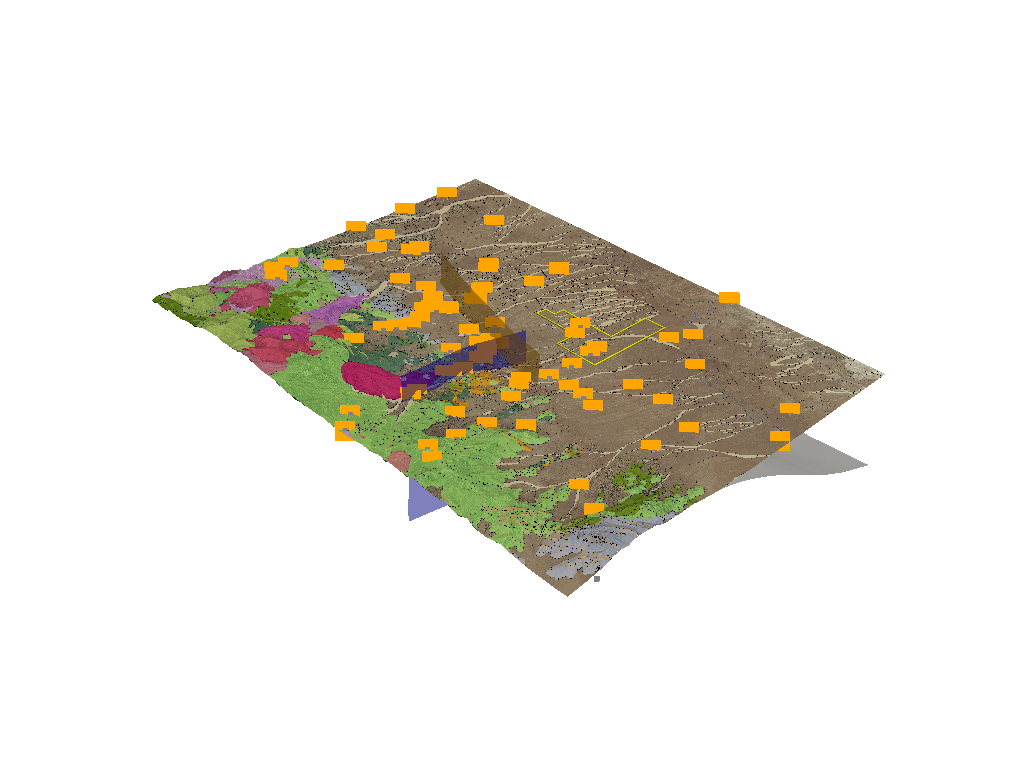

In [50]:
def fig_1(p, bounds=None):
    add_topo(p, bounds)
    add_faults(p, bounds)
    add_granite(p, bounds)
    add_boundary(p, bounds)
    add_well_collars(p, bounds)
    add_well_traj(p, bounds)
    add_wells_with_data_solid(p, bounds)

p = vtki.Plotter(notebook=1)
fig_1(p)
p.show()

**Figure 1 Legend:**
- Faults (blue and yellow planes)
- Granite (dark grey)
- FORGE site (yellow outline)
- Well Locations (orange dots)
- Well Trajectories (grey)

**The well locations should be reduced a bit in size**
[(318581.0684416248, 4238878.125869998, 10502.443569695455),
 (337504.84888541873, 4261501.390341784, 138.79188840111613),
 (0.2275750741088043, 0.24175047512873182, 0.943274240833176)]

# Figure 2
This figure shows a model of Milford Valley, Utah with topography, fault, granite, FORGE site and well, well logs, and temperature locations and data

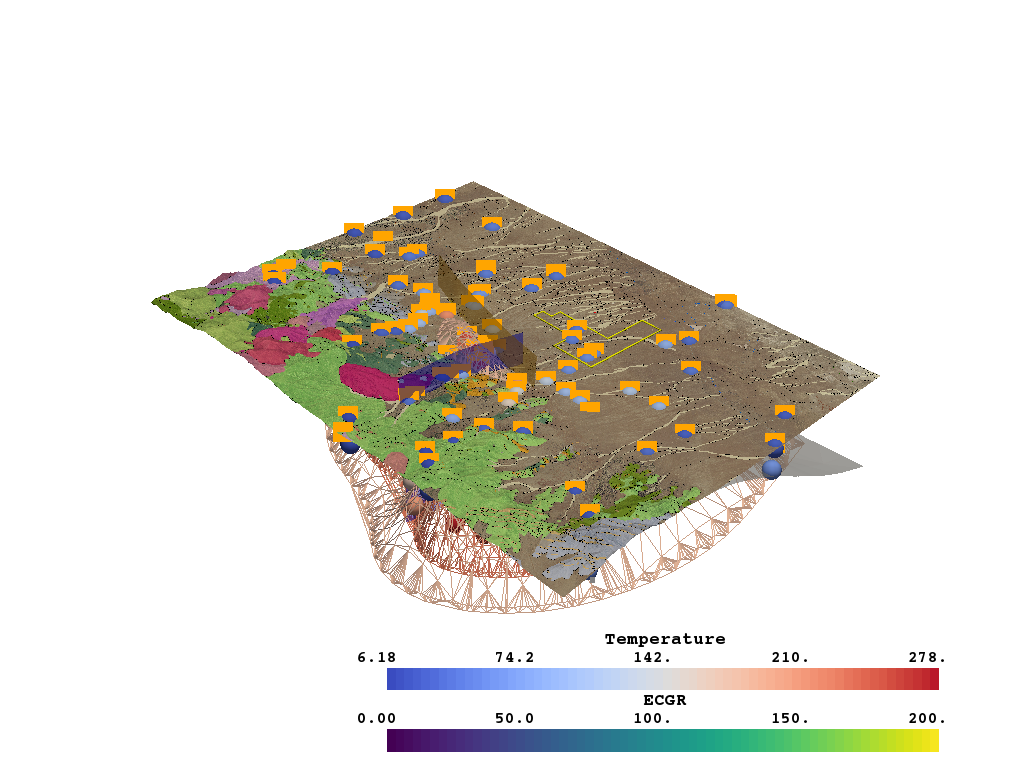

In [52]:
def fig_2(p, bounds=None):
    fig_1(p, bounds)
    add_wells_with_data(p, bounds)
    add_temp_probes(p, bounds)
    add_temp_surfs(p, bounds)

p = vtki.Plotter(notebook=1)
fig_2(p)
p.show()

**Figure 2 Legend:**
- Faults (blue and yellow planes)
- Granite Layer (dark grey)
- FORGE site (yellow outline)
- Well Locations (orange dots)
- Well Trajectories (grey)


- Gamma Ray Well Logs on Acord1 and 58-32 (colored well trajectories) 
- Temperature Mesh for 175ºC (pink) and 225ºC (red)
- Temperature Probe (blue to red colored dots)

**The Temperature dots should be reduced a bit in size**
[(324945.55139959423, 4290999.83325066, -195.7848689208751),
 (336909.4650625, 4261896.229565, 150.0),
 (0.002129643806474512, 0.012755630937123225, 0.9999163757518195)]

# Figure 3
This figure shows a model of Milford Valley, Utah cropped from the north side of the FORGE site to better view the subsurface within the FORGE boundary

In [15]:
gdc19.get_roi_bounds()

[329924.98816, 344152.930125, 4252833.48213, 4270951.09811, -5000.0, 5000.0]

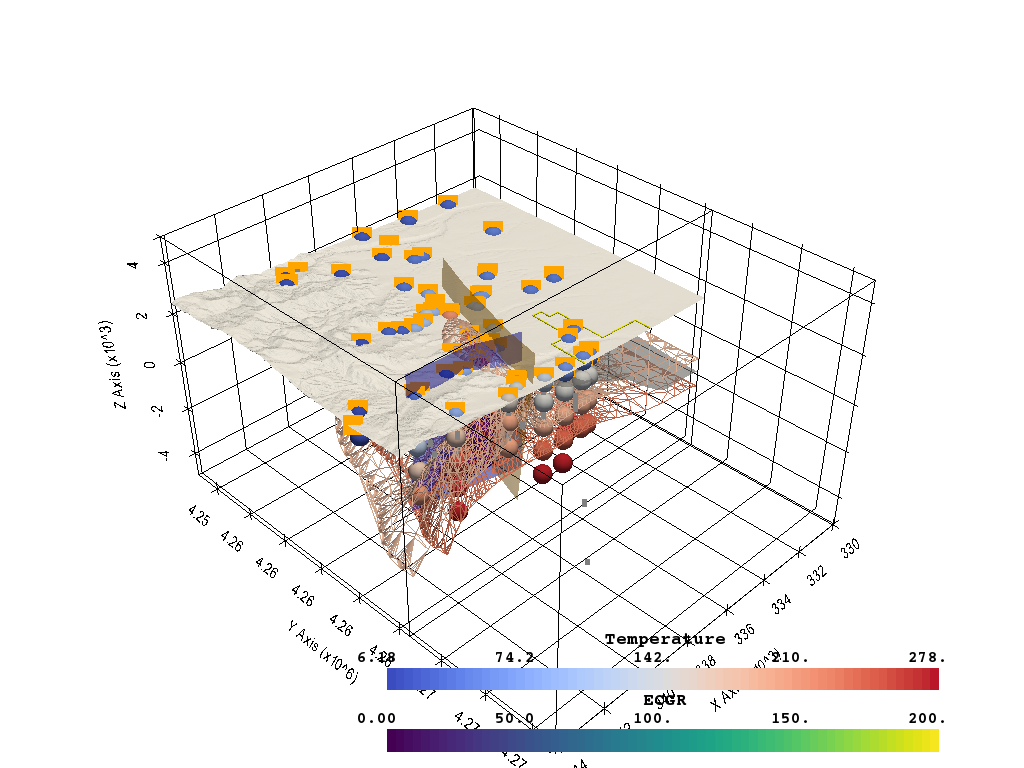

In [45]:
ROI_BOX = [329924.98816, 344152.930125, 4252833.48213,
              4264500., 
           -5000.0, 5000.0]

def fig_3(p, bounds=None):
    fig_2(p, bounds)
    p.add_mesh(vtki.Box(gdc19.get_roi_bounds()).outline(), color='k')
    p.add_mesh(vtki.Box(ROI_BOX).outline(), color='k')


p = vtki.Plotter(notebook=1)
fig_3(p, ROI_BOX)
p.show_grid()
p.show()


**Figure 3 Legend:**
- Faults (blue and yellow planes)
- Granite Layer (dark grey)
- FORGE site (yellow outline)
- Well Locations (orange dots)
- Well Trajectories (grey)
- Gamma Ray Well Logs on Acord1 and 58-32 (colored well trajectories) 
- Temperature Mesh for 175ºC (pink) and 225ºC (red)
- Temperature Probe (blue to red colored dots)

[(326221.223619594, 4269153.062663502, -655.0668370754465),
 (335817.3117049677, 4261819.79840792, -190.75734756687143),
 (-0.02827962420855367, 0.026262494408348065, 0.9992549946045177)]

# Figure 4

This figure shows a model of Milford Valley, Utah cropped to better view the FORGE site subsurface and includes our team's proposed well location and trajectory (red).

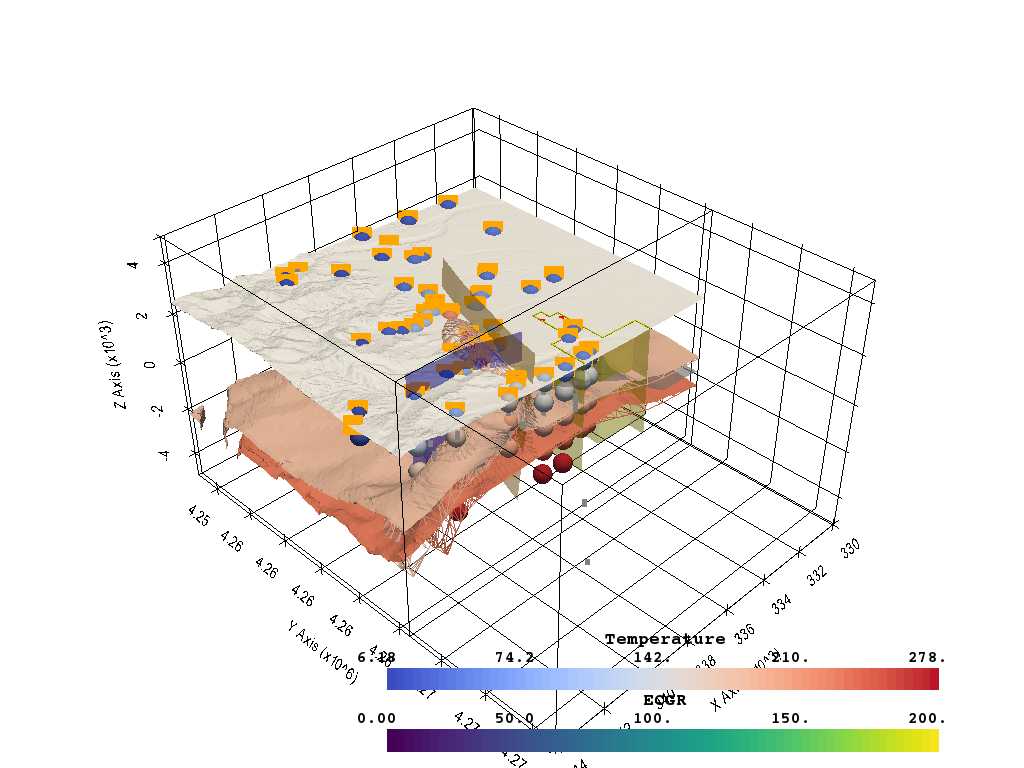

In [48]:
def fig_4(p, bounds=None):
    fig_3(p, bounds)
    add_well_traj_proposed(p, bounds)
    add_temp_model(p, bounds)
    add_walls(p, bounds)
    
    
    
p = vtki.Plotter(notebook=1)
fig_4(p, ROI_BOX)
p.show_grid()
p.show()

**Figure 4 Legend:**
- Faults (blue and yellow planes)
- Granite Layer (dark grey)
- FORGE site (yellow outline)
- Well Locations (orange dots)
- Well Trajectories (grey)
- Gamma Ray well logs on Acord1 and 58-32 (colored well trajectories) 
- Temperature Mesh for 175ºC (pink) and 225ºC (red)
- Temperature Probe (blue to red colored dots)


- Proposed Well (red)

[(337947.2777284753, 4274251.077437216, 3782.0155544797108),
 (336819.79099209886, 4262069.125704545, -160.4863747958867),
 (-0.10091855957877652, -0.2978718905088982, 0.9492564359419429)]

# Figure 5

This figure shows a model of Milford Valley, Utah with topography, fault, granite, FORGE site and well, well logs, proposed well, temperature, and gravity locations and data

In [ ]:
##Place here

Figure 5 Data:
- Topography
- Faults (blue and yellow planes)
- Granite Layer (dark grey)
- FORGE site (yellow outline)
- Well Locations (orange dots)
- Well Trajectories (grey)
- Gamma Ray well logs on Acord1 and 58-32 (colored well trajectories) 
- Temperature Mesh for 175ºC (pink) and 225ºC (red)
- Temperature Probe (blue to red colored dots)
- Proposed Well (red)


- Gravity Data across Milford Valley (colored)

In [47]:
#We seem to have a couple figures left, so what if we add one identical
#to figure 4 but a view from the front side (granite slopes up into
#the page)